In [123]:
from matplotlib import pyplot as plt

In [124]:
EXPERIMENT="./results/mf_config_2021_11_17T17_31_03/stdout"

In [134]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys

pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_colwidth', 100) 

main_metric='ndcg@40'

def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result


def get_metrics_internal(result, line):
    metrics = line.split(",")
    for metric in metrics:
        name, value = metric.split(":")
        result[name.strip()] = float(value.strip())
    return result 

def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    experiment_finished = True
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
                experiment_finished = False
                epoch = 0
            if 'val_ndcg_at_40' in line:
                    epoch += 1
                    epoch_metrics = get_metrics(line)
                    epoch_metrics['epoch'] = epoch
            if 'best_ndcg' in line:
                epoch_metrics = get_metrics_internal(epoch_metrics, line)
                metrics.append(epoch_metrics)

            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
                experiment_finished = True
            except:
                pass
    if not experiment_finished:
        experiment_results = {}
        experiment_results['model_name'] =  current_recommender
        experiment_results['metrics_history'] = metrics
        result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

experiment_logs_file = EXPERIMENT
data = get_data_from_logs(experiment_logs_file, 0)
df = pd.DataFrame(data).set_index('model_name').sort_values(main_metric)
del df['model_metadata']
del df['metrics_history']
del df['SPS@10']


In [135]:
len(df)

427

In [136]:
values = defaultdict(lambda: {'ndcg': [], 'training_time': []})
for model_name in df.index:
    if model_name.startswith("mf_"):
        fixed_model_name = model_name[3:].replace("binary_crossentropy", "bce")
        params = fixed_model_name.split("_")
        model_params = {}
        for param in params:
            key, value = param.split(":")
            try:
                value = int(value)
            except:
                try:
                    value = float(value)
                except:
                    pass
            model_params[key] = value
        values[model_params['loss']]['ndcg'].append(df.loc[model_name][main_metric])
        #values[model_params['loss']]['training_time'].append(model_params['epochs'])
        values[model_params['loss']]['training_time'].append(df.loc[model_name]['model_build_time'])

In [137]:
def pareto_front(x, y, is_dominated_by):
    result = []
    for i in range(len(x)):
        point1 = (x[i], y[i])
        on_pareto_front = True
        for j in range(len(x)):
            if i == j:
                continue
            point2 = (x[j], y[j])
            on_pareto_front &= not is_dominated_by(point1, point2)
        result.append(on_pareto_front)
    return result

In [138]:
def min_max_dominated_by(point1, point2):
    return (point2[0] < point1[0]) and (point2[1] >= point1[1]) or  (point2[0] <= point1[0]) and (point2[1] > point1[1])

In [139]:
df["on_pareto_front"] = pareto_front(df["model_build_time"], df[main_metric], min_max_dominated_by)

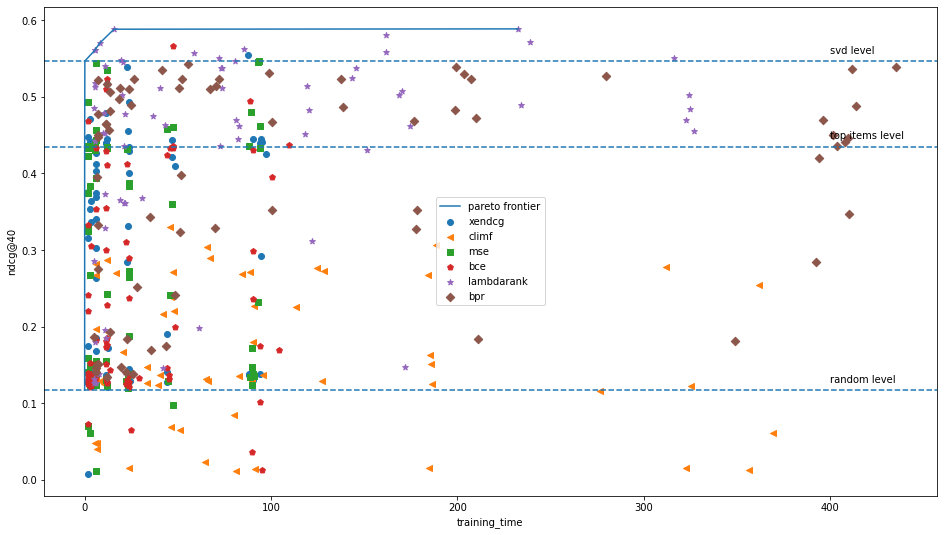

In [140]:
markers = ('o','<', 's', 'p', '*', 'D', 'd', 'P', 'X')
plt.figure(figsize=(16, 9))
i = 0
for loss in values:
    plt.scatter(values[loss]['training_time'], values[loss]['ndcg'], label=loss, marker=markers[i])
    i+=1
    
svd_level = df.loc['svd_recommender_32'][main_metric]
plt.axhline(y = svd_level, linestyle = '--')
plt.text(400, svd_level+0.01,  "svd level")

top_items_level = df.loc['top_recommender'][main_metric]
plt.axhline(y = top_items_level, linestyle = '--')
plt.text(400, top_items_level + 0.01,  "top items level")

random_level = df.loc['random_recommender'][main_metric]
plt.axhline(y = random_level, linestyle = '--')
plt.text(400, random_level + 0.01,  "random level")

plt.xlabel('training_time')
plt.ylabel(main_metric)


pareto_optimal = df[df.on_pareto_front].sort_values("model_build_time")
pareto_x = pareto_optimal["model_build_time"]
pareto_y = pareto_optimal[main_metric]
plt.plot(pareto_x, pareto_y, label="pareto frontier")
plt.legend()


In [141]:
pareto_optimal

,ndcg@40,precision@5,recall@5,MRR,MAP@10,model_build_time,model_inference_time,on_pareto_front
model_name,,,,,,,,
random_recommender,0.117032,0.016331,0.002871,0.056934,0.001592,0.000023,0.504947,True
top_recommender,0.434970,0.260233,0.040519,0.439408,0.047886,0.000962,0.278883,True
svd_recommender_32,0.546690,0.274867,0.083664,0.492941,0.078532,0.112361,0.929819,True
mf_epochs:16_emb:256_reg:0.1_loss:lambdarank_bs:64_lr:0.01,0.560748,0.260233,0.081359,0.446563,0.072176,5.457127,38.350223,True
mf_epochs:32_emb:512_reg:1.0_loss:lambdarank_bs:512_lr:0.01,0.569908,0.284624,0.086886,0.481335,0.077986,8.017155,38.203163,True
mf_epochs:64_emb:32_reg:2.0_loss:lambdarank_bs:512_lr:0.1,0.588196,0.325981,0.077958,0.531433,0.075357,15.761871,37.975002,True
mf_epochs:1024_emb:16_reg:2.0_loss:lambdarank_bs:512_lr:0.1,0.588604,0.330011,0.082267,0.538833,0.076328,232.701311,38.160598,True
mf_epochs:512_emb:16_reg:0.0001_loss:climf_bs:256_lr:0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [142]:
df.tail(10)

,ndcg@40,precision@5,recall@5,MRR,MAP@10,model_build_time,model_inference_time,on_pareto_front
model_name,,,,,,,,
mf_epochs:16_emb:512_reg:0.0001_loss:lambdarank_bs:64_lr:0.001,0.560525,0.272959,0.078610,0.464347,0.070967,5.605388,38.304112,False
mf_epochs:16_emb:256_reg:0.1_loss:lambdarank_bs:64_lr:0.01,0.560748,0.260233,0.081359,0.446563,0.072176,5.457127,38.350223,True
mf_epochs:256_emb:256_reg:0.0001_loss:lambdarank_bs:64_lr:0.0001,0.561966,0.278049,0.078836,0.462299,0.073971,85.487851,38.600223,False
mf_epochs:512_emb:32_reg:0.0001_loss:binary_crossentropy_bs:128_lr:0.001,0.565816,0.296076,0.071469,0.499064,0.072143,47.548682,38.016846,False
mf_epochs:32_emb:512_reg:1.0_loss:lambdarank_bs:512_lr:0.01,0.569908,0.284624,0.086886,0.481335,0.077986,8.017155,38.203163,True
mf_epochs:1024_emb:128_reg:1.0_loss:lambdarank_bs:512_lr:0.01,0.571382,0.282503,0.085270,0.464953,0.074613,239.063121,37.836632,False
mf_epochs:512_emb:1024_reg:4.0_loss:lambdarank_bs:64_lr:0.001,0.580984,0.335737,0.073211,0.566413,0.073872,161.608974,38.845046,False
mf_epochs:64_emb:32_reg:2.0_loss:lambdarank_bs:512_lr:0.1,0.588196,0.325981,0.077958,0.531433,0.075357,15.761871,37.975002,True
mf_epochs:1024_emb:16_reg:2.0_loss:lambdarank_bs:512_lr:0.1,0.588604,0.330011,0.082267,0.538833,0.076328,232.701311,38.160598,True


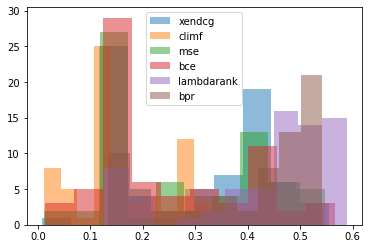

In [122]:
for loss in values:
    plt.hist(values[loss]['ndcg'], label=loss, alpha=0.5)
    i+=1
    plt.legend()